#Load Data from Kaggle

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d validmodel/indo-fashion-dataset

 99% 2.68G/2.69G [00:39<00:00, 61.4MB/s]
100% 2.69G/2.69G [00:39<00:00, 73.6MB/s]


In [3]:
!unzip indo-fashion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/val/3251.jpeg    
  inflating: images/val/3252.jpeg    
  inflating: images/val/3253.jpeg    
  inflating: images/val/3254.jpeg    
  inflating: images/val/3255.jpeg    
  inflating: images/val/3256.jpeg    
  inflating: images/val/3257.jpeg    
  inflating: images/val/3258.jpeg    
  inflating: images/val/3259.jpeg    
  inflating: images/val/326.jpeg     
  inflating: images/val/3260.jpeg    
  inflating: images/val/3261.jpeg    
  inflating: images/val/3262.jpeg    
  inflating: images/val/3263.jpeg    
  inflating: images/val/3264.jpeg    
  inflating: images/val/3265.jpeg    
  inflating: images/val/3266.jpeg    
  inflating: images/val/3267.jpeg    
  inflating: images/val/3268.jpeg    
  inflating: images/val/3269.jpeg    
  inflating: images/val/327.jpeg     
  inflating: images/val/3270.jpeg    
  inflating: images/val/3271.jpeg    
  inflating: images/val/3272.jpeg    
  inflating: images/val/3273.jpeg    

#Dataset Pruning

In [ ]:
import json

classLabels = set()

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    classLabels.add(sample.get('class_label'))

In [ ]:
classLabels

{'blouse',
 'dhoti_pants',
 'dupattas',
 'gowns',
 'kurta_men',
 'leggings_and_salwars',
 'lehenga',
 'mojaris_men',
 'mojaris_women',
 'nehru_jackets',
 'palazzos',
 'petticoats',
 'saree',
 'sherwanis',
 'women_kurta'}

In [ ]:
import json

selected_samples=[]
counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}
with open('/content/train_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    #print(sample['class_label'])
    #break
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      if(counts[label]<200):
        selected_samples.append(sample)
        counts[label]=counts[label]+1

In [ ]:
n_samples=len(selected_samples)
print(f"No. of samples after pruning - {n_samples}")
print("Distribution of samples: \n")
print(counts)

No. of samples after pruning - 1600
Distribution of samples: 

{'gowns': 200, 'kurta_men': 200, 'lehenga': 200, 'nehru_jackets': 200, 'palazzos': 200, 'saree': 200, 'sherwanis': 200, 'women_kurta': 200}


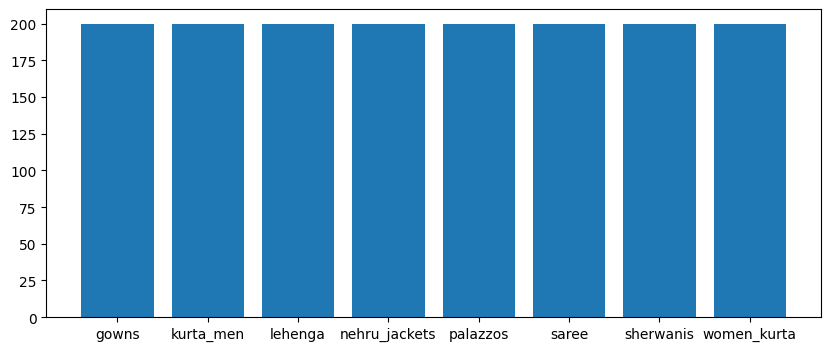

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(counts.keys(), counts.values(), alpha=1)
plt.show()

In [ ]:
selected_samples[0]

{'image_url': 'https://m.media-amazon.com/images/I/81XKaSKvlyL._AC_UL320_.jpg',
 'image_path': 'images/train/0.jpeg',
 'brand': 'Womanista',
 'product_title': "Women's Georgette Saree with Blouse Piece (TKIM811_Black_Free Size)",
 'class_label': 'saree'}

In [ ]:
import pandas as pd
train_df = pd.DataFrame(selected_samples)

In [ ]:
train_df.head()

,image_url,image_path,brand,product_title,class_label
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,Womanista,Women's Georgette Saree with Blouse Piece (TKI...,saree
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,Yashika,Women Linen Printed Sarees Free Size (BEE),saree
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,Womanista,Organza Floral Print Saree with Blouse Piece(W...,saree
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,PERFECTBLUE,Women's Digital Cotton Linen Blend Saree with ...,saree
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,VAIVIDHYAM,Designer Sarees Women's Banarasi Cotton Silk S...,saree


In [ ]:
train_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
train_df.head()

In [ ]:
train_df.to_csv("pruned_train_data.csv", index=False)

In [ ]:
test_selected_samples=[]
test_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/test_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      test_selected_samples.append(sample)
      test_counts[label]=test_counts[label]+1

In [ ]:
n_test_samples=len(test_selected_samples)
print(f"No. of test samples after pruning - {n_test_samples}")
print("Distribution of test samples: \n")
print(test_counts)

No. of test samples after pruning - 4000
Distribution of test samples: 

{'gowns': 500, 'kurta_men': 500, 'lehenga': 500, 'nehru_jackets': 500, 'palazzos': 500, 'saree': 500, 'sherwanis': 500, 'women_kurta': 500}


In [ ]:
test_df = pd.DataFrame(test_selected_samples)
test_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
test_df.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/71NZQ-aaAS...,images/test/0.jpeg,saree
1,https://m.media-amazon.com/images/I/81aQmbWsG7...,images/test/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71YjGvzs9y...,images/test/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81JYhYV5Xr...,images/test/3.jpeg,saree
4,https://m.media-amazon.com/images/I/91fXc5i5Dy...,images/test/4.jpeg,saree


In [ ]:
test_df.to_csv("pruned_test_data.csv",index=False)

In [ ]:
val_selected_samples=[]
val_counts={'gowns':0,
 'kurta_men':0,
 'lehenga':0,
 'nehru_jackets':0,
 'palazzos':0,
 'saree':0,
 'sherwanis':0,
 'women_kurta':0}

with open('/content/val_data.json', 'r') as file:
  for line in file:
    sample = json.loads(line)
    if(sample['class_label'] not in ['blouse','leggings_and_salwars','mojaris_men','mojaris_women','dhoti_pants','petticoats', 'dupattas']):
      label = sample.get('class_label')
      val_selected_samples.append(sample)
      val_counts[label]=val_counts[label]+1

In [ ]:
n_val_samples=len(val_selected_samples)
print(f"No. of valiadation samples after pruning - {n_val_samples}")
print("Distribution of validation samples: \n")
print(val_counts)

No. of valiadation samples after pruning - 4000
Distribution of validation samples: 

{'gowns': 500, 'kurta_men': 500, 'lehenga': 500, 'nehru_jackets': 500, 'palazzos': 500, 'saree': 500, 'sherwanis': 500, 'women_kurta': 500}


In [ ]:
val_df = pd.DataFrame(val_selected_samples)
val_df.drop(columns=['brand', 'product_title', 'color'], inplace=True)
val_df.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81LOPbFPiQ...,images/val/0.jpeg,saree
1,https://m.media-amazon.com/images/I/81Q8Oktw4s...,images/val/1.jpeg,saree
2,https://m.media-amazon.com/images/I/613S1YGCmo...,images/val/2.jpeg,saree
3,https://m.media-amazon.com/images/I/819budhQl1...,images/val/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61cAZ94ZQV...,images/val/4.jpeg,saree


In [ ]:
val_df.to_csv("pruned_val_data.csv",index=False)

#Dataset Loading

In [4]:
import pandas as pd
training_data = pd.read_csv('/content/pruned_train_data.csv')
training_data.head()

,image_url,image_path,class_label
0,https://m.media-amazon.com/images/I/81XKaSKvly...,images/train/0.jpeg,saree
1,https://m.media-amazon.com/images/I/91dDMDg+QT...,images/train/1.jpeg,saree
2,https://m.media-amazon.com/images/I/71TJ9p46PV...,images/train/2.jpeg,saree
3,https://m.media-amazon.com/images/I/81Y+je7CEg...,images/train/3.jpeg,saree
4,https://m.media-amazon.com/images/I/61B8o9Ulqp...,images/train/4.jpeg,saree


In [5]:
training_data.shape

(20000, 3)

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class FashionDataset(Dataset):
    def __init__(self, dataframe, label_map, transform=None):
        self.data = dataframe
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = Image.open(img_path)
        label = self.label_map[(self.data.iloc[idx, 2])]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
from torch.utils.data import DataLoader

label_map = {'gowns': 0, 'kurta_men': 1, 'lehenga': 2, 'nehru_jackets': 3,
             'palazzos': 4, 'saree': 5, 'sherwanis': 6, 'women_kurta': 7}

train_data = FashionDataset(dataframe = training_data, label_map = label_map, transform = transform)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [8]:
validation_data = pd.read_csv('/content/pruned_val_data.csv')

val_data = FashionDataset(dataframe = validation_data, label_map = label_map, transform = transform)
val_dataloader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [12]:
testing_data = pd.read_csv('/content/pruned_test_data.csv')

test_data = FashionDataset(dataframe = testing_data, label_map = label_map, transform = transform)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

#VGG16

In [9]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using "+str(device))

vgg16 = models.vgg16(weights=None)
vgg16.classifier[-1] = nn.Linear(4096, 8) # 8 output classes
vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Using cuda


In [10]:
import torch
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):

    vgg16.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):

        inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_dataloader):

            inputs, labels = inputs.cuda().to(device), labels.cuda().to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_dataloader)}], Val Loss: {loss.item():.4f}')

    val_loss /= len(val_dataloader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

print('Training complete')

Epoch [1/5], Batch [1/313], Train Loss: 2.0785
Epoch [1/5], Batch [2/313], Train Loss: 2.1104
Epoch [1/5], Batch [3/313], Train Loss: 2.0798
Epoch [1/5], Batch [4/313], Train Loss: 2.0842
Epoch [1/5], Batch [5/313], Train Loss: 2.0747
Epoch [1/5], Batch [6/313], Train Loss: 2.0973
Epoch [1/5], Batch [7/313], Train Loss: 2.0594
Epoch [1/5], Batch [8/313], Train Loss: 2.0731
Epoch [1/5], Batch [9/313], Train Loss: 2.0590
Epoch [1/5], Batch [10/313], Train Loss: 2.0570
Epoch [1/5], Batch [11/313], Train Loss: 2.0851
Epoch [1/5], Batch [12/313], Train Loss: 2.0837
Epoch [1/5], Batch [13/313], Train Loss: 2.0635
Epoch [1/5], Batch [14/313], Train Loss: 2.0949
Epoch [1/5], Batch [15/313], Train Loss: 2.0495
Epoch [1/5], Batch [16/313], Train Loss: 2.0673
Epoch [1/5], Batch [17/313], Train Loss: 2.0648
Epoch [1/5], Batch [18/313], Train Loss: 2.0709
Epoch [1/5], Batch [19/313], Train Loss: 2.0463
Epoch [1/5], Batch [20/313], Train Loss: 2.0567
Epoch [1/5], Batch [21/313], Train Loss: 2.0856
E

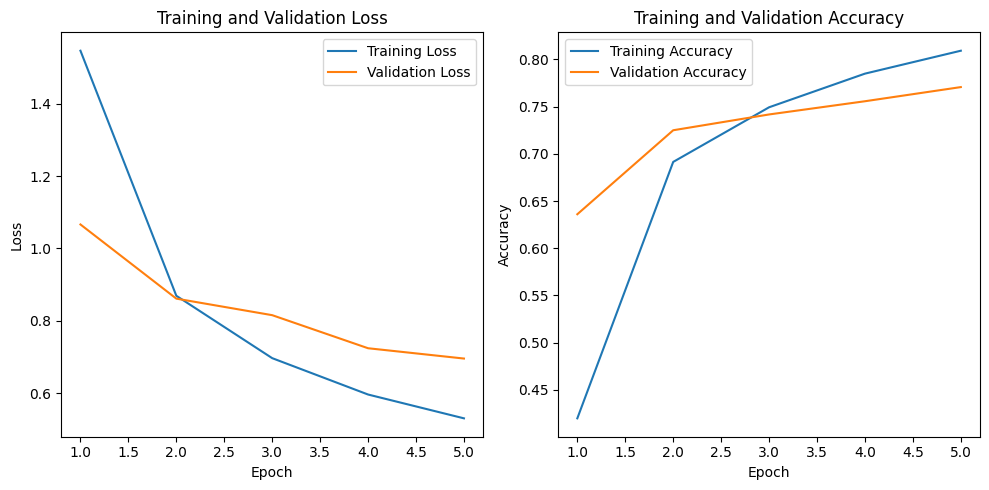

In [11]:
import matplotlib.pyplot as plt

# training and validation loss

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Testing Accuracy: 78.025
Testing Loss: 0.6705535898208618
F1 Score: 0.777005300633843


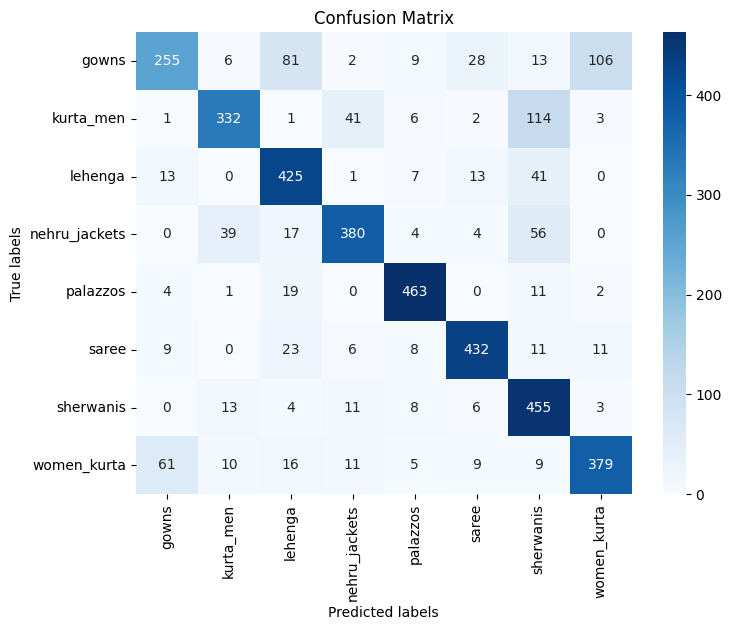

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

accuracy_history = []
loss_history = []

def test_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            accuracy = correct / total
            loss_history.append(loss.item())
            accuracy_history.append(accuracy)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total)*100
    test_loss = test_loss / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return test_accuracy, test_loss, f1, cm

test_accuracy, test_loss, f1, confusion_matrix = test_model(vgg16, test_dataloader, criterion, device)

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')
print(f'F1 Score: {f1}')

# conf matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

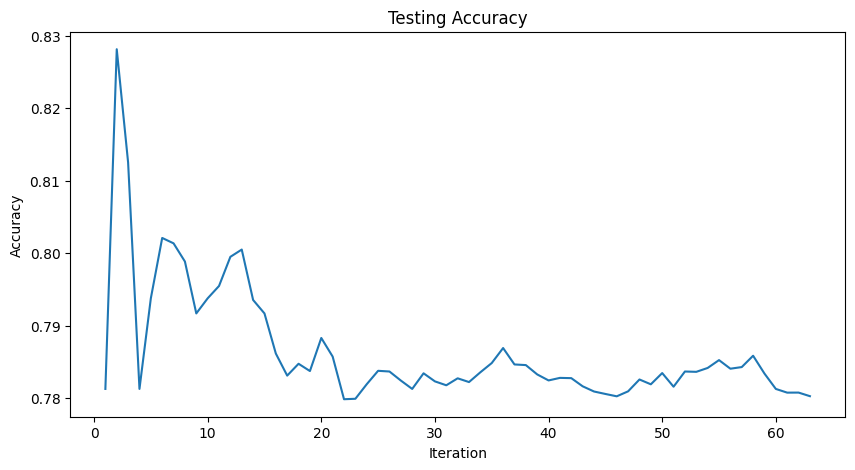

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.show()